# validating tsinfer/tsdate tree sequence inference. 
## test 1: contemporaneous tips + recombination

This notebook is a continuation of present.ipynb. Here, I perform topological inference (tsinfer) and internal node dating (tsdate) using the proxy method and varying parameters: recombination_rate AND mismatch_ratio. I plot the relationship between chosen parameter values and number of infered trees. I perform multivariate linear regressions (n = 40) to validate whether the inferred tree sequences are accurately dated. 

### import modules

In [1]:
import tsinfer
import tskit
import msprime
import tsdate
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LinearRegression
from itertools import combinations
import seaborn as sns

### simulate ancestry
I use msprime to simulate a geneology of 25 individuals sampled contemporaneously at time = 0 with a fixed recombination rate. 

In [2]:
ts = msprime.sim_ancestry(
    samples = [
        msprime.SampleSet(25, time=0, ploidy = 1),
        #msprime.SampleSet(10, time=10, ploidy = 1),
        #msprime.SampleSet(5, time=50, ploidy = 1)
    ],
    ploidy = 1, 
    sequence_length=1e6,
    random_seed=50,
    recombination_rate=1e-6
)

### simulate mutations onto geneology 
I set a mutation rate onto the geneology. (Note: if I apply too low of a mutation rate, sampled genomes end up being too similar and tsinfer fails to reconstruct topology accurately.) 

In [3]:
ts = msprime.sim_mutations(ts, rate = 3e-5, random_seed = 42) 

The final simulated tree sequence contains 6 trees (i.e. 5 recombination breakpoints) and 256 mutations. 

In [4]:
ts

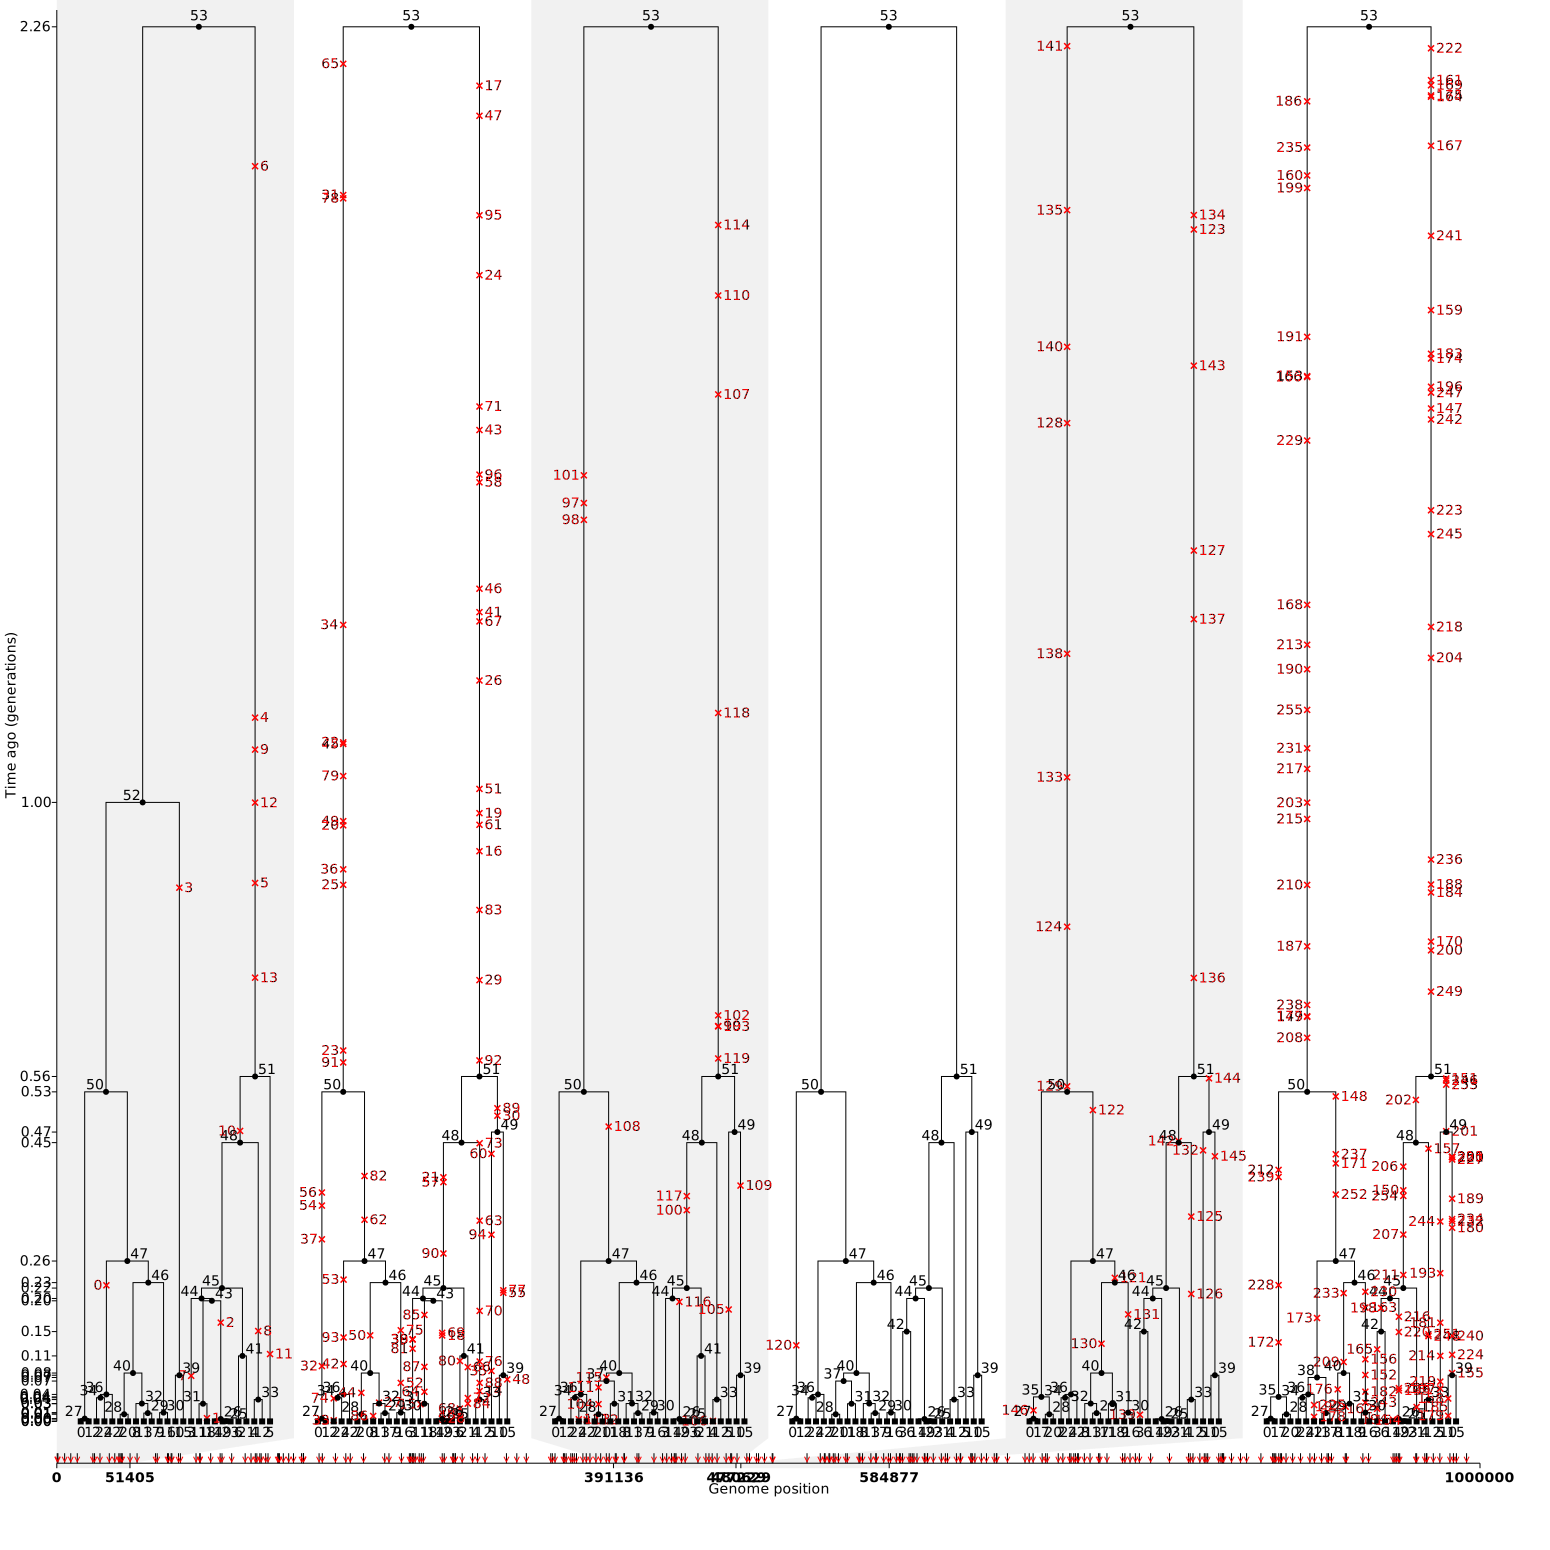

In [5]:
ts.draw_svg(size=(1500, 1500),
 canvas_size=(1550, 1550),
         y_axis=True
        )

### date internal nodes of simulated tree sequence

In [6]:
sampling_times = ts.nodes_time[0:25]

In [7]:
dated_ts = tsdate.date(ts, 
                       mutation_rate=3e-5, # same mutation rate used for simulation 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True
                       )



In [8]:
# integer value assigned to each individual in the tree. used for indexing purposes later on. 
samples = list(dated_ts.samples())

### export as vcf and import as vcz
Tsinfer can only read in VCZ files. I export the geneology as a VCF, translate to VCZ (bio2zarr), then reimport.

In [9]:
# with open(f"../data/present_sim.vcf", "w") as fh: 
#     ts.write_vcf(output = fh)

In [10]:
# get ancestral states
ancestral_states = []

for site in ts.sites():
    if site.ancestral_state is None:
        ancestral_states.append("N")
        #print("N")
    else:
        ancestral_states.append(str(site.ancestral_state))
        #print(site.ancestral_state)

ancestral_states = np.array(ancestral_states)

Creating vdata object 

In [11]:
vdata = tsinfer.VariantData("../data/vcz_files/present.vcz", 
                            ancestral_state=ancestral_states,
                           individuals_time=sampling_times)

## run inference
Reinfers the topological/temporal structure of the simulated tree sequences under varying rr (recombination rate) and mm (mismatch ratio). Called by rr_mm() and rr() functions. Returns rr and mm value used to produce tree sequence, as well as the dated simulated tree sequence. 

In [12]:
def run_inference2(vdata, rr_value = None, mm_value = None): 
    
    if rr_value != None:
        rr = rr_value 
        mm = mm_value
    else: 
        rr = None
        mm = None
        

    anc = tsinfer.generate_ancestors(vdata)
    anc_ts = tsinfer.match_ancestors(vdata, anc, recombination_rate = rr, mismatch_ratio = mm)
    ts = tsinfer.match_samples(vdata, anc_ts, recombination_rate = rr)
    simplified_ts = tsdate.preprocess_ts(ts, erase_flanks=False)

    dated_ts = tsdate.date(simplified_ts, 
                       mutation_rate=3e-5, 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True,
                       #rescaling_intervals = 492
                       )
    
    return rr, mm, dated_ts
     

### get tree width

In [13]:
def get_intervals(dated_ts): 

    data = []
    
    for tree in dated_ts.trees():
        left, right = tree.interval
        data.append({
            "tree_index": tree.index,
            "left": left,
            "right": right,
        })
    
    intervals = pd.DataFrame(data)

    return intervals


### get mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the simulated tree sequence.

In [14]:
def sims_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(0, dated_ts.get_num_trees()):
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the inferred tree sequence.

In [15]:
def res_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(1, dated_ts.get_num_trees()-1): #flanking trees are not informative and must be trimmed
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

In [16]:
# def lg(mrcas):
#     X = mrcas["proxy"].values.reshape(-1, 1)
#     y = mrcas["sim"].values
#     weights = mrcas["width"]/1e6
#     reg = LinearRegression().fit(X, y, weights)
#     return X, y, reg, weights


### varying recombination rate and mismatch_ratio during inference

Produces an array of recombination rates and mismatch ratios , then calls run_inference to infer tree sequences under varying parameters. Returns counts (for indexing), metadata (tree index, rr and mm values), and seqs(a list of tree sequences). 

In [17]:
def rr_mm(vdata): 
    
    rates = [10**x for x in range(-8, 0, 1)]
    rates.append(None)

    mms = [10**x for x in range(-3, 1, 1)]
    #mms.append(None) 
    
    grid_num_trees = np.zeros(shape=(11, 4))
    seqs = [] #save each ts here 
    
    count = 0
    nones = 0

    metadata = [] 
    counts = []
    for rr_idx, rr_value in enumerate(rates):
        for mm_idx, mm_value in enumerate(mms): 

            if nones > 0: 
                break

            if rr_value == None:
                mm_value = 1
                nones += 1 
            
            count+=1
            
            rr, mm, ip = run_inference2(vdata, rr_value, mm_value)
            
            grid_num_trees[rr_idx][mm_idx] = ip.num_trees
            
            seqs.append(ip) 

            metadata.append({"index": count-1, "rate": rr, "mm": mm})

            counts.append({"rate": rr, "mm": mm, "num_trees": ip.num_trees}) 

            print(f"Finished inference {count}/{len(rates)}. RR: {rr_value}, MM: {mm_value}, num trees: {ip.num_trees}")

    return pd.DataFrame(counts), pd.DataFrame(metadata), seqs 


### run inference

Here, I run rr_mm which produces N tree sequences with varying numbers of recombination breakpoints. 

In [18]:
counts, metadata, seqs = rr_mm(vdata)

Finished inference 1/9. RR: 1e-08, MM: 0.001, num trees: 11
Finished inference 2/9. RR: 1e-08, MM: 0.01, num trees: 11
Finished inference 3/9. RR: 1e-08, MM: 0.1, num trees: 11
Finished inference 4/9. RR: 1e-08, MM: 1, num trees: 8
Finished inference 5/9. RR: 1e-07, MM: 0.001, num trees: 11
Finished inference 6/9. RR: 1e-07, MM: 0.01, num trees: 11
Finished inference 7/9. RR: 1e-07, MM: 0.1, num trees: 11
Finished inference 8/9. RR: 1e-07, MM: 1, num trees: 8
Finished inference 9/9. RR: 1e-06, MM: 0.001, num trees: 11
Finished inference 10/9. RR: 1e-06, MM: 0.01, num trees: 11
Finished inference 11/9. RR: 1e-06, MM: 0.1, num trees: 11
Finished inference 12/9. RR: 1e-06, MM: 1, num trees: 8
Finished inference 13/9. RR: 1e-05, MM: 0.001, num trees: 11
Finished inference 14/9. RR: 1e-05, MM: 0.01, num trees: 11
Finished inference 15/9. RR: 1e-05, MM: 0.1, num trees: 11
Finished inference 16/9. RR: 1e-05, MM: 1, num trees: 8
Finished inference 17/9. RR: 0.0001, MM: 0.001, num trees: 12
Fin

#### get mrca dfs for simulated tree

In [19]:
rates = [10**x for x in range(-8, 0, 1)]
rates.append("None")

In [20]:
sim_list = sims_times(dated_ts, samples) 

#### get mrca dfs for each tree (w/ varying mm)

In [21]:
rates = [10**x for x in range(-8, 0, 1)]
rates.append("None")

In [22]:
mms = [10**x for x in range(-3, 1, 1)]
#mms.append(None)

In [23]:
res_list = []

for id, ts in enumerate(seqs): 
    df = res_times(ts, samples)
    df['rr'] = str(metadata[metadata.index==id].rate.iloc[0]) ###  
    df['mm'] = str(metadata[metadata.index==id].mm.iloc[0]) #### 
    res_list.append(df) 

# Analysis

## plot relationship between parameter value choice (rr, mm) and number of inferred trees

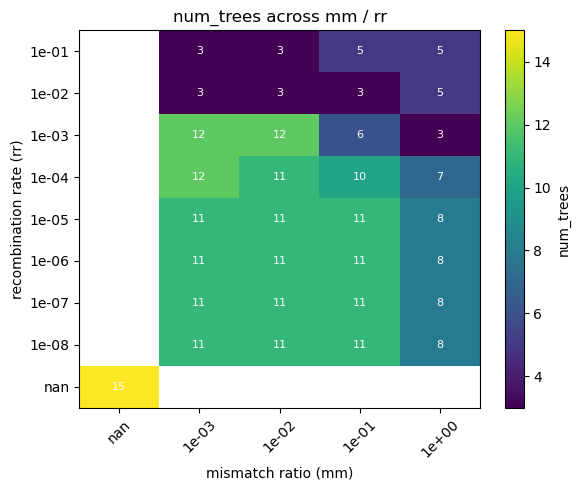

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = counts.copy()

# replace NAs with string
df["rr"] = df["rate"].astype(float)
df["mm"] = df["mm"].apply(lambda x: "nan" if pd.isna(x) else float(x))

# rows = rr (Y), columns = mm (X)
pivot_trees = df.pivot(index="rr", columns="mm", values="num_trees")

# sort axes so NAs are first 
cols = pivot_trees.columns.tolist()
cols_sorted = ["nan"] if "nan" in cols else []
cols_sorted += sorted([c for c in cols if c != "nan"], key=lambda x: float(x))
pivot_trees = pivot_trees[cols_sorted]
pivot_trees = pivot_trees.sort_index(ascending=False)

# plot heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(pivot_trees.values, aspect='auto', cmap='viridis')

# annotate cells with num_trees
for i in range(pivot_trees.shape[0]):
    for j in range(pivot_trees.shape[1]):
        val = pivot_trees.iloc[i, j]
        if not np.isnan(val):
            plt.text(j, i, int(val), ha='center', va='center', color='white', fontsize=8)

# colorbar and ticks
plt.colorbar(im, label='num_trees')
plt.xticks(
    range(len(pivot_trees.columns)),
    [str(c) if c == "nan" else f"{float(c):.0e}" for c in pivot_trees.columns],
    rotation=45
)
plt.yticks(
    range(len(pivot_trees.index)),
    [f"{float(y):.0e}" for y in pivot_trees.index]
)

# labeling
plt.xlabel('mismatch ratio (mm)')
plt.ylabel('recombination rate (rr)')
plt.title('num_trees across mm / rr')
plt.tight_layout()
plt.show()


#### Takeaways
-  Looks like recombination rates 1e-8 to 1e-5 produce accurate number of trees 
- mismatch ratio of 1 is most accurate (mm = NaN seems to default to 1, so the first and last cols are identical) 

## multivariate linear regressions on pairwise MRCAs, weighted by time/genome fraction

explanation: instead of doing tree-by-tree analysis according to breakpoint overlap, just regress through dates as was done in the original (non-recombinant) case. 

In [25]:
# res_list # 40 X dataframes. contains a, b, mrca(a,b), rr, mm, width

In [26]:
sim_list # Y dataframe. contains a, b, mrca(a, b) 

,index,sample_a,sample_b,mrca,width,left,right
0,0,0,1,0.003397,51405.0,0.0,51405.0
1,1,0,1,0.003397,339731.0,51405.0,391136.0
2,2,0,1,0.003397,86093.0,391136.0,477229.0
3,3,0,1,0.003397,3400.0,477229.0,480629.0
4,4,0,1,0.003397,104248.0,480629.0,584877.0
...,...,...,...,...,...,...,...
1795,1,23,24,2.379799,339731.0,51405.0,391136.0
1796,2,23,24,2.379799,86093.0,391136.0,477229.0
1797,3,23,24,2.379799,3400.0,477229.0,480629.0
1798,4,23,24,2.379799,104248.0,480629.0,584877.0


In [27]:
def _pivot_mrca(df):
    dfu = df.drop_duplicates(subset=['sample_a','sample_b','index'])
    mat = dfu.pivot(index=['sample_a','sample_b'], columns='index', values='mrca').sort_index()
    widths = (dfu.drop_duplicates('index')
                .set_index('index')['width']
                .reindex(mat.columns).astype(float))
    return mat, widths

In [28]:
# pass one simulated DataFrame (sim_df) and one inferred DataFrame (inf_df), 
# pass ridge_alpha penalty to combat collinearity of adjacent trees in a sequence 
# pass fit_intercept to learn a per-target (i.e per tree) intercept 

def fit_mvr_simple(sim_df, inf_df, ridge_alpha=1e-3, fit_intercept=True):
    """
    Fit Y ≈ X B + c with genomic width-based scaling.
    Returns B, intercept, R², and MAE metrics.

    MAE overall: average absolute error across all pairs and all simulated trees (unweighted).
    MAE per target: average absolute error for each simulated tree (one value per tree).
    MAE weighted: same as MAE, but simulated trees that cover more genome count more.
    
    R2 per target: R² for each simulated tree separately.
    R2 weighted: R² aggregated across trees, weighted by simulated-tree genome span.
    
    """
    # Build matrices
    # Rows = sample pairs (sample_a, sample_b).
    # Columns = tree index (index).
    # Values = MRCA
    # wY genome span of simulated trees; wX genome span of inferred tree 
    
    Y_df, wY = _pivot_mrca(sim_df)   # targets: simulated trees (i columns)
    X_df, wX = _pivot_mrca(inf_df)   # predictors: inferred trees (j columns)

    # Align on (sample_a, sample_b) -- ( going to regress through dates, not matching up trees based on overlap )
    Y = Y_df.to_numpy() # (num_pairs × num_sim_trees)
    X = X_df.to_numpy() # (num_pairs × num_inf_trees)
    
    # intercept (columnwise centering): center tree by subtracting average across pairs  
    # basically: “when a sample pair MRCA is older/younger than average in inferred tree j, 
    # how does that predict being older/younger than average in simulated tree i?”
    if fit_intercept:
        X_mean = X.mean(axis=0, keepdims=True) # average MRCA across all sample-pairs for that tree
        Y_mean = Y.mean(axis=0, keepdims=True)
        Xc = X - X_mean # tree centered 
        Yc = Y - Y_mean
    else:
        X_mean = np.zeros((1, X.shape[1])) 
        Y_mean = np.zeros((1, Y.shape[1]))
        Xc, Yc = X, Y


    # James: "I think you can simply weight the values in these matricies according
    # to genomic distances, exactly as you have been doing. You sometimes see this 
    # in matrix form as X^hat = X.V where V is a diagonal matrix of the weights vector.
    # But from what I can read you might need to take the square root of the weights..."
    
    # Column scaling by sqrt(width) to put more emphasis on wide spanning trees
    wY = wY.to_numpy() #first do pd->np alignment
    sY = np.sqrt(wY / wY.mean()) # weight targets by span (scaled Y) 
    
    sX = np.ones(X.shape[1]) # not going to scale the predictors, just the targets (is this fine?) 
    
    # apply scaling 
    Xcs = Xc * sX # (X centered * X scale factors) = X centered + scaled 
    Ycs = Yc * sY # (Y centered * Y scale factors) = Y centered + scaled 

    # solve (Xcs^T Xcs + αI) B_s = Xcs^T Ycs 
    XtX = Xcs.T @ Xcs
    XtY = Xcs.T @ Ycs
    if ridge_alpha and ridge_alpha > 0: # adds penalty to prevent coefficients from blowing up 
                                        # due to X cols being super correlated w/ eachother.
                                        # this might happen b/c in a tree seq, neighboring trees have 
                                        # overlapping info. using ridge-alpha = 0 does result in overfitting (single matrix)
        XtX = XtX + ridge_alpha * np.eye(XtX.shape[0])
    B_s = np.linalg.solve(XtX, XtY)

    # unscale: B = (diag(1/sX)) @ B_s @ diag(1/sY)
    B = B_s / sY  # divide each column by sY
    B = (B.T / sX).T  # divide each row by sX

    # solve for intercepts (one per simulated tree)
    c = (Y_mean - X_mean @ B).ravel() if fit_intercept else np.zeros(Y.shape[1])

    # Predictions & residuals
    Yhat = X @ B + c
    resid = Y - Yhat

    # Metrics: per-target SSE/SST and R²
    ybar = Y.mean(axis=0)
    sse = np.sum(resid**2, axis=0)
    sst = np.sum((Y - ybar)**2, axis=0)
    with np.errstate(divide='ignore', invalid='ignore'):
        r2 = 1.0 - sse / sst
        r2[np.isnan(r2)] = np.nan

    # MAE per target, overall MAE, and width-weighted aggregates (by simulated widths)
    mae_per = np.mean(np.abs(resid), axis=0)
    mae_overall = float(np.mean(np.abs(resid)))
    #wYv = wY.to_numpy()
    r2_weighted = float(1.0 - np.sum(wY * sse) / np.sum(wY * sst)) if np.sum(wY*sst) > 0 else np.nan
    mae_weighted = float(np.sum(wY * mae_per) / np.sum(wY)) if np.sum(wY) > 0 else np.nan

    return {
        "B": B, "intercept": c, "Yhat": Yhat,
        "r2_per_target": r2, "r2_weighted": r2_weighted,
        "mae_per_target": mae_per, "mae_weighted": mae_weighted, "mae_overall": mae_overall,
        "x_columns": X_df.columns.to_numpy(), "y_columns": Y_df.columns.to_numpy()
    }

In [29]:
def run_all(sim_df, inferred_list, ridge_alpha):
    rows, fits = [], []
    for k, inf_df in enumerate(inferred_list):
        fit = fit_mvr_simple(sim_df, inf_df, ridge_alpha)
        fits.append(fit)
        rows.append({
            "inferred_id": k,
            "r2_weighted": fit["r2_weighted"],
            "mae_weighted": fit["mae_weighted"],
            "mae_overall": fit["mae_overall"],
            "num_sim_trees": len(fit["y_columns"]),
            "num_inf_trees": len(fit["x_columns"]),
        })
    return pd.DataFrame(rows).sort_values("r2_weighted", ascending=False), fits

In [30]:
# using a ridge_alpha because adjacent trees are correlated/colinear with eachother. 
# this only really effects r2 but mae is the same. 

summary, fits = run_all(sim_list, res_list, ridge_alpha=1e-3)
summary.head()          # has r2_weighted, mae_weighted, mae_overall

,inferred_id,r2_weighted,mae_weighted,mae_overall,num_sim_trees,num_inf_trees
16,16,0.994884,0.016662,0.035673,6,10
15,15,0.994667,0.020240,0.039563,6,6
3,3,0.994667,0.020240,0.039563,6,6
11,11,0.994667,0.020240,0.039563,6,6
7,7,0.994667,0.020240,0.039563,6,6


# Visualize results

## 1. Distribution of R2 and MAE across runs. 
### For most runs, R2/MAE looks pretty good. 

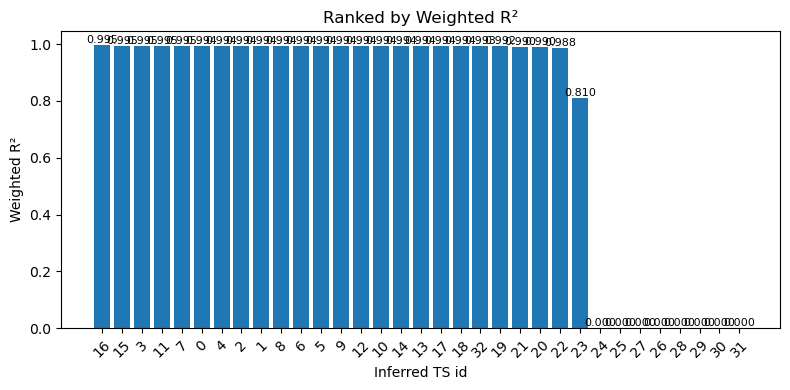

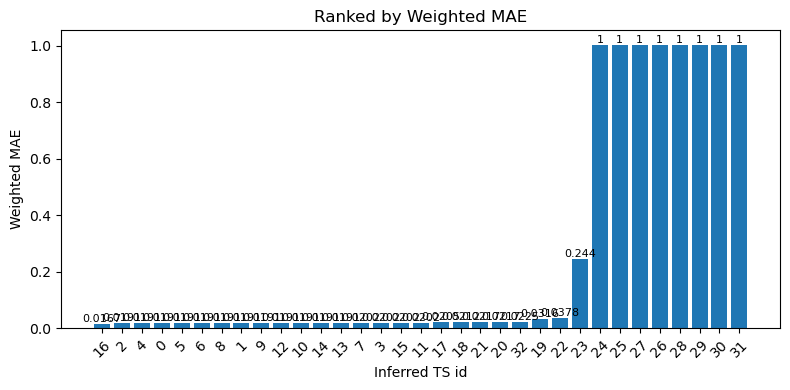

In [40]:
def top5_summary(summary):
    sort_cols = ["r2_weighted", "mae_weighted"]
    asc = [False, True]
    if "mae_overall" in summary.columns:
        sort_cols.append("mae_overall")
        asc.append(True)
    return summary.sort_values(sort_cols, ascending=asc).head(33).copy()

def plot_top5_r2(summary):
    s = top5_summary(summary)
    x = s["inferred_id"].astype(str).to_numpy()
    y = s["r2_weighted"].to_numpy()
    plt.figure(figsize=(8, 4))
    plt.bar(x, y)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f"{yi:.3f}", ha="center", va="bottom", fontsize=8)
    plt.xlabel("Inferred TS id")
    plt.ylabel("Weighted R²")
    plt.title("Ranked by Weighted R²")
    plt.xticks(rotation=45)
    plt.tight_layout()

def plot_top5_mae(summary):
    s = top5_summary(summary).sort_values("mae_weighted", ascending=True)
    x = s["inferred_id"].astype(str).to_numpy()
    y = s["mae_weighted"].to_numpy()
    plt.figure(figsize=(8, 4))
    plt.bar(x, y)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f"{yi:.3g}", ha="center", va="bottom", fontsize=8)
    plt.xlabel("Inferred TS id")
    plt.ylabel("Weighted MAE")
    plt.title("Ranked by Weighted MAE")
    plt.xticks(rotation=45)
    plt.tight_layout()

plot_top5_r2(summary)
plot_top5_mae(summary)

It looks like MAE and R2 scores are all pretty reasonable until you get to inferred trees where recombination rate parameter is very low (indexes 23-31). 

In [37]:
metadata[20:32]

,index,rate,mm
20,20,0.001,0.001
21,21,0.001,0.010
22,22,0.001,0.100
23,23,0.001,1.000
24,24,0.010,0.001
25,25,0.010,0.010
26,26,0.010,0.100
27,27,0.010,1.000
28,28,0.100,0.001
29,29,0.100,0.010


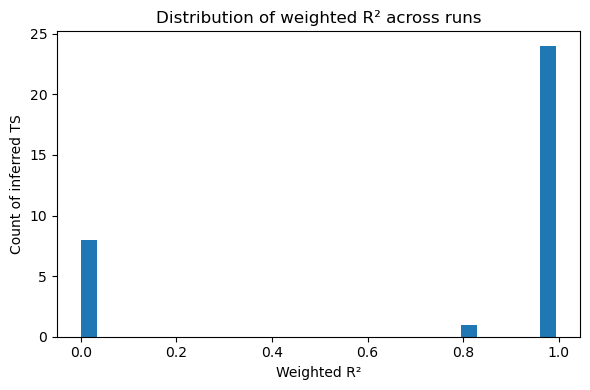

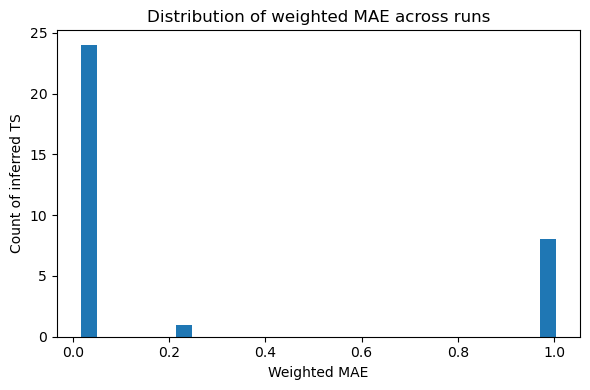

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metric_distributions(summary):
    plt.figure(figsize=(6,4))
    plt.hist(summary["r2_weighted"].dropna(), bins=30)
    plt.xlabel("Weighted R²")
    plt.ylabel("Count of inferred TS")
    plt.title("Distribution of weighted R² across runs")
    plt.tight_layout()

    plt.figure(figsize=(6,4))
    plt.hist(summary["mae_weighted"].dropna(), bins=30)
    plt.xlabel("Weighted MAE")
    plt.ylabel("Count of inferred TS")
    plt.title("Distribution of weighted MAE across runs")
    plt.tight_layout()

plot_metric_distributions(summary)


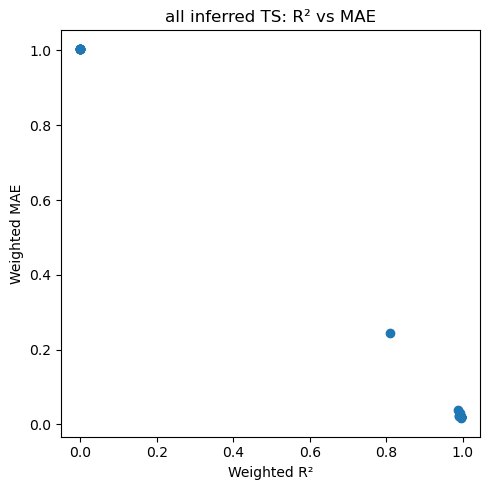

In [52]:
plt.figure(figsize=(5,5))
plt.scatter(summary["r2_weighted"], summary["mae_weighted"])
plt.xlabel("Weighted R²")
plt.ylabel("Weighted MAE")
plt.title("all inferred TS: R² vs MAE")
plt.tight_layout()


## 2. Check how well inferred tree sequences match up to particular simulated trees. 

#### The first tree in the simulated tree sequence tends to be difficult to recapitulate across runs. This might just be because it's unique, since the inferred trees arent explicitly being matched up to any simulated tree. 
#### All trees for the latter inferred tree sequences struggle to recapitulate the MRCAs in the simulated sequence. 

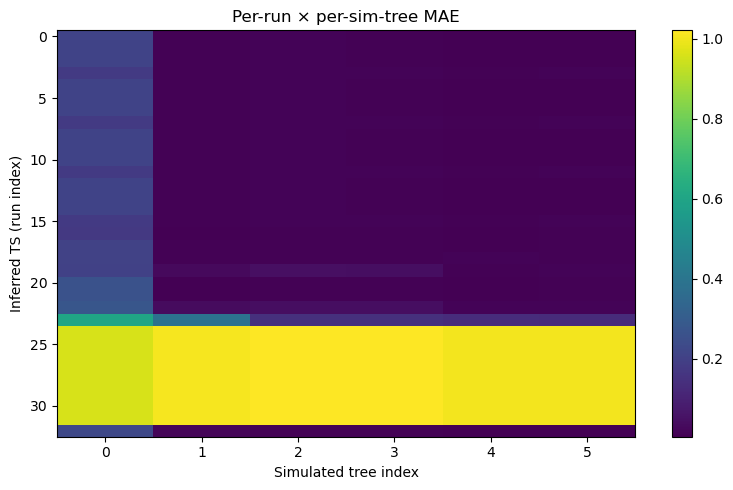

In [54]:
def plot_mae_heatmap(fits, title=None):
    mae_mat = np.stack([f["mae_per_target"] for f in fits], axis=0)  # shape: runs × sim_trees
    plt.figure(figsize=(8,5))
    plt.imshow(mae_mat, aspect="auto", interpolation="nearest")
    plt.colorbar()
    plt.xlabel("Simulated tree index")
    plt.ylabel("Inferred TS (run index)")
    if title: plt.title(title)
    plt.tight_layout()

plot_mae_heatmap(fits, title="Per-run × per-sim-tree MAE")


In [57]:
dated_ts.at_index(0)

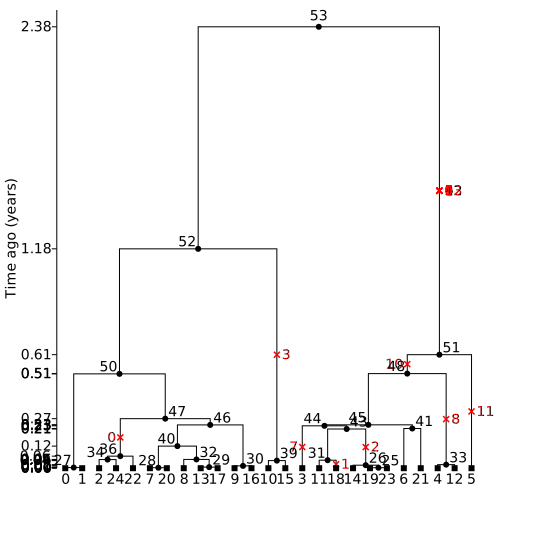

In [60]:
dated_ts.at_index(0).draw_svg(size=(500, 500),
 canvas_size=(550, 550),
         y_axis=True
        )

Some inferred trees do recapitulate this simulated tree pretty well, but most don't. could be a unique structure or something so on average, most inferred trees aren't similar to this one. 

Median MAE: 0.20995036904497474


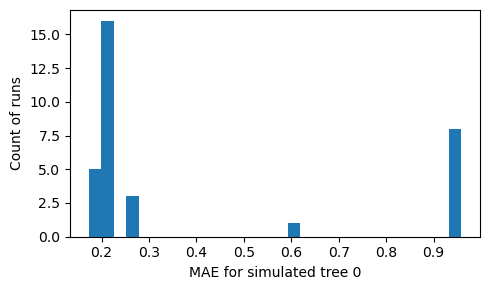

In [65]:
import numpy as np, matplotlib.pyplot as plt

t = 0  # the simulated tree (column) with most errors
mae_t = np.array([f["mae_per_target"][t] for f in fits])
plt.figure(figsize=(5,3))
plt.hist(mae_t, bins=30)
plt.xlabel(f"MAE for simulated tree {t}")
plt.ylabel("Count of runs"); plt.tight_layout()
print("Median MAE:", float(np.median(mae_t)))


#### For super shallow MRCAS, error tends to be higher.

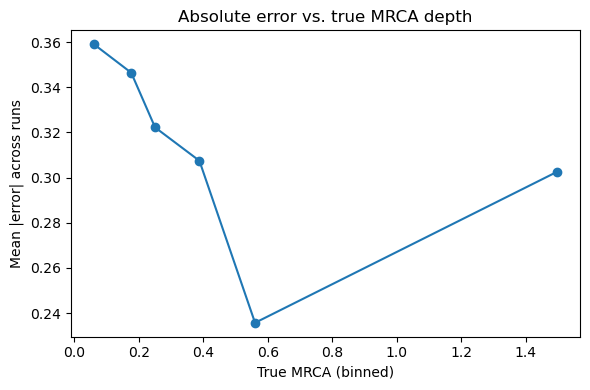

In [63]:
def plot_error_vs_truth_binned(sim_list, fits, nbins=12):
    Y_df, _ = _pivot_mrca(sim_list)
    Y = Y_df.to_numpy().ravel()
    abs_err_all = []
    y_true_all  = []
    for f in fits:
        abs_err_all.append(np.abs((Y_df.to_numpy() - f["Yhat"])).ravel())
        y_true_all.append(Y)
    abs_err_all = np.concatenate(abs_err_all)
    y_true_all  = np.concatenate(y_true_all)

    # bin by true MRCA
    edges = np.quantile(y_true_all, np.linspace(0, 1, nbins+1))
    mids  = 0.5*(edges[:-1] + edges[1:])
    mean_err = []
    for a, b in zip(edges[:-1], edges[1:]):
        mask = (y_true_all >= a) & (y_true_all < b)
        mean_err.append(np.mean(abs_err_all[mask]) if np.any(mask) else np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(mids, mean_err, marker="o")
    plt.xlabel("True MRCA (binned)")
    plt.ylabel("Mean |error| across runs")
    plt.title("Absolute error vs. true MRCA depth")
    plt.tight_layout()

plot_error_vs_truth_binned(sim_list, fits)
